# In class assignment 1: TensorFlow and Keras

 [Machine Learning 2019-1](https://fagonzalezo.github.io/ml-2019-1/)


---

In [14]:
import numpy as np
import pylab as pl
import tensorflow as tf
from IPython.display import clear_output, Image, display, HTML
from sklearn.datasets.samples_generator import make_moons

%matplotlib inline

# Functions for plotting 2D data and decision regions
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=[color],
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")

def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 30)
    y_vals = np.linspace(min_y, max_y, 30)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 30, cmap = pl.cm.coolwarm, vmin= 0, vmax=1)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")

In [15]:
# Helper functions to inline visualization of computing graphs
# Extracted from: 
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))


### 1. Multilayer neural network in TensorFlow

You need to create a neural network model in TF that is able to discriminate the two classes in the following dataset:

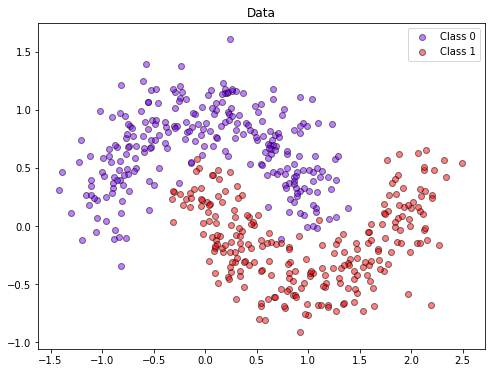

In [16]:
X, Y = make_moons(n_samples = 1000, noise = 0.2, random_state = 3)
x_train = X[:500]
x_test  = X[500:]
y_train = Y[:500]
y_test  = Y[500:]

pl.figure(figsize = (8, 6))
plot_data(x_train, y_train)

For this you will need to create a neural network with one hidden layer. You cannot use prebuilt models 
such as those in `tf.estimator`. **Hint**: extend the logistic regression example from the TensorFlow handout. 

Your answer must contain the following:
* A visualization of the CG of the model.
* A visualization of the decision region along with the test data.
* A snapshot from TensorBoard that shows the evolution of the training and test loss.

In [124]:
graph = tf.Graph()
with graph.as_default():
    x = tf.placeholder(tf.float32,shape=[None,2])
    y_true = tf.placeholder(tf.float32,shape=None)
    
    with tf.name_scope('s1') as scope:
        w_0 = tf.Variable([[1,1]], dtype=tf.float32, name='weights_0')
        b_0 = tf.Variable(0,dtype=tf.float32,name='bias_0')
        y_pred_0 = 1/(1 + tf.exp(-(tf.matmul(w_0,tf.transpose(x)) + b_0)))
        print(y_pred_0)
        
    with tf.name_scope('s2') as scope:
        w_1 = tf.Variable([[1,1]], dtype=tf.float32, name='weights_1')
        b_1 = tf.Variable(0,dtype=tf.float32,name='bias_1')
        y_pred_1 = 1/(1 + tf.exp(-(tf.matmul(w_1,tf.transpose(x)) + b_1)))   
        print(y_pred_1)
        
    with tf.name_scope('inference') as scope:
        w = tf.Variable([[1,1]],dtype=tf.float32,name='weights')
        b = tf.Variable(0,dtype=tf.float32,name='bias')
        y_pred = w[0,0]*y_pred_0 + w[0,1]*y_pred_1 + b

    with tf.name_scope('loss') as scope:
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = y_true, logits = y_pred)
        loss = tf.reduce_mean(loss)
  
    with tf.name_scope('train') as scope:
        learning_rate = 1.00
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        train = optimizer.minimize(loss)

    init = tf.global_variables_initializer()

show_graph(graph.as_graph_def())

Tensor("s1/truediv:0", shape=(1, ?), dtype=float32)
Tensor("s2/truediv:0", shape=(1, ?), dtype=float32)


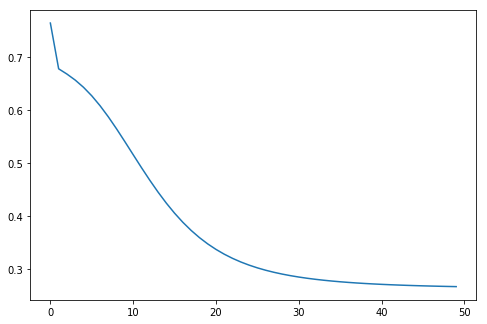

In [125]:
num_epochs = 250
losses = []

with graph.as_default():
    sess = tf.Session()
    sess.run(init)      
    for step in range(num_epochs):
        sess.run(train,{x: x_train, y_true: y_train})
        if (step % 5 == 0):
            losses.append(sess.run(loss, {x: x_train, y_true: y_train}))
                       
pl.figure(figsize = (8,16/3))
pl.plot(losses)


[[3.997872 3.997872]]
[[-3.3381035]]


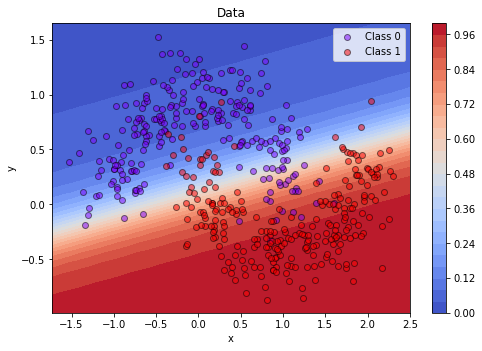

In [126]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

with graph.as_default():
    wval = sess.run(w)
    print(wval)
    result = sess.run(y_pred, {x:np.array([[1,2]])})
    print(result)
    def pred_fun(x1, x2):
        xval = np.array([[x1, x2]])
        return sigmoid(sess.run(y_pred,{x: xval}))

pl.figure(figsize = (8,16/3))    
plot_decision_region(x_test, pred_fun)
plot_data(x_test, y_test)

### 2. Improving the Keras text classifier

Your goal is to improve the performance of the text classifier in the Keras handout. This is are the things that you need to try:

* Different activation functions for the hidden layer (https://keras.io/activations/)
* Different optimizers (https://keras.io/optimizers/)
* Add dropout between the hidden layer and the output layer (https://keras.io/layers/core/#dropout)
* Different initializers for the dense layers (https://keras.io/initializers/)

Try different combinations and report your findings at the end. Which configuration got the best accuracy in test?
